# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Описание данных
### Технологический процесс

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions ) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate ** — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

### Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

## Наименование признаков
Наименование признаков должно быть такое:

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]` :
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока `[тип_параметра]` :
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Наименование признаков
Наименование признаков должно быть такое:

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]` :
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока `[тип_параметра]` :
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Расчёт эффективности
Вам нужно смоделировать процесс восстановления золота из золотосодержащей
руды.
Эффективность обогащения рассчитывается по формуле
$$
Recovery = \frac{C \times (F-T)}{F \times (C-T)} \times 100 \%
$$
где:
- $C$ — доля золота в концентрате после флотации/очистки;
- $F$ — доля золота в сырье/концентрате до флотации/очистки;
- $T$ — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах.
Причём важен не только финальный продукт, но и черновой концентрат.

## Метрика качества
Для решения задачи введём новую метрику качества — ***sMAPE*** (англ. Symmetric Mean
Absolute Percentage Error , «симметричное среднее абсолютное процентное
отклонение»).

Она похожа на *MAE* , но выражается не в абсолютных величинах, а в относительных.
Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и
предсказания.

Метрика *sMAPE* вычисляется так:
$$
sMAPE = \frac1N \sum_{i=1}^N \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|)/2} \times 100\%
$$

Обозначения:
- $y_i$ - Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
- $\hat{y}_i$ - Значение предсказания для объекта с порядковым номером i , например, в тестовой выборке.
- $N$ - Количество объектов в выборке.
- $\sum_{i=1}^N$ - Суммирование по всем объектам выборки ( i меняется от 1 до N ).

Нужно спрогнозировать сразу две величины:
1. эффективность обогащения чернового концентрата `rougher.output.recovery` ;
2. эффективность обогащения финального концентрата `final.output.recovery` .

Итоговая метрика складывается из двух величин:

$$
sMAPE = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)
$$

# Описание проекта
Данные находятся в трёх файлах:
- gold_recovery_train.csv — обучающая выборка;
- gold_recovery_test.csv — тестовая выборка;
- gold_recovery_full.csv — исходные данные.

Данные индексируются датой и временем получения информации
(признак `date`). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или
рассчитываются значительно позже. Из-за этого в тестовой выборке
отсутствуют некоторые признаки, которые могут быть в обучающей.
Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми
признаками.

В вашем распоряжении сырые данные: их просто выгрузили из
хранилища. Прежде чем приступить к построению модели, проверьте
по нашей инструкции их на корректность.

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import numpy as np

In [2]:
# настройки
pd.set_option('float_format', '{:,.2f}'.format)

In [3]:
# универсальное чтение данных
names = [
    'gold_recovery_train.csv',
    'gold_recovery_test.csv',
    'gold_recovery_full.csv',
]

try:
    # local
    df_train= pd.read_csv("./datasets/" + names[0], index_col=0, parse_dates=True)
    df_test = pd.read_csv("./datasets/" + names[1], index_col=0, parse_dates=True)
    df_full = pd.read_csv("./datasets/" + names[2], index_col=0, parse_dates=True)
except:
    try:
        # https://jupyterhub.praktikum-services.ru/
        df_train= pd.read_csv("/datasets/" + names[0], index_col=0, parse_dates=True)
        df_test = pd.read_csv("/datasets/" + names[1], index_col=0, parse_dates=True)
        df_full = pd.read_csv("/datasets/" + names[2], index_col=0, parse_dates=True)
    except:
        # https://praktikum.yandex.ru/
        df_train= pd.read_csv("https://..." + names[0], index_col=0, parse_dates=True)
        df_test = pd.read_csv("https://..." + names[1], index_col=0, parse_dates=True)
        df_full = pd.read_csv("https://..." + names[2], index_col=0, parse_dates=True)
finally:
    print(df_train.info(verbose=False))
    display(df_train.head(2))
    print()
    print(df_test.info(verbose=False))
    display(df_test.head(2))
    print()
    print(df_full.info(verbose=False))
    display(df_full.head(2)) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Columns: 86 entries, final.output.concentrate_ag to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(86)
memory usage: 11.2 MB
None


final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2016-01-15 00:00:00                         6.06                         9.89   
2016-01-15 01:00:00                         6.03                         9.97   

                     final.output.concentrate_sol  \
date                                                
2016-01-15 00:00:00                          5.51   
2016-01-15 01:00:00                          5.26   

                     final.output.concentrate_au  final.output.recovery  \
date                                                                      
2016-01-15 00:00:00                        42.19                  70.54   
2016-01-15 01:00:00                        42.70                  69.27   

                     final.output.tail_ag  final.output.tail_pb  \
date                                                              
2016-01-15 00:00:00                 10.41                  0.90   
2016-01-15 01:00:00                 10.46                  0.93   

                     final.output.tail_sol  final.output.tail_au  \
date                                                               
2016-01-15 00:00:00                  16.90                  2.14   
2016-01-15 01:00:00                  16.63                  2.22   

                     primary_cleaner.input.sulfate  ...  \
date                                                ...   
2016-01-15 00:00:00                         127.09  ...   
2016-01-15 01:00:00                         125.63  ...   

                     secondary_cleaner.state.floatbank4_a_air  \
date                                                            
2016-01-15 00:00:00                                     14.02   
2016-01-15 01:00:00                                     13.99   

                     secondary_cleaner.state.floatbank4_a_level  \
date                                                              
2016-01-15 00:00:00                                     -502.49   
2016-01-15 01:00:00                                     -505.50   

                     secondary_cleaner.state.floatbank4_b_air  \
date                                                            
2016-01-15 00:00:00                                     12.10   
2016-01-15 01:00:00                                     11.95   

                     secondary_cleaner.state.floatbank4_b_level  \
date                                                              
2016-01-15 00:00:00                                     -504.72   
2016-01-15 01:00:00                                     -501.33   

                     secondary_cleaner.state.floatbank5_a_air  \
date                                                            
2016-01-15 00:00:00                                      9.93   
2016-01-15 01:00:00                                     10.04   

                     secondary_cleaner.state.floatbank5_a_level  \
date                                                              
2016-01-15 00:00:00                                     -498.31   
2016-01-15 01:00:00                                     -500.17   

                     secondary_cleaner.state.floatbank5_b_air  \
date                                                            
2016-01-15 00:00:00                                      8.08   
2016-01-15 01:00:00                                      7.98   

                     secondary_cleaner.state.floatbank5_b_level  \
date                                                              
2016-01-15 00:00:00                                     -500.47   
2016-01-15 01:00:00                                     -500.58   

                     secondary_cleaner.state.floatbank6_a_air  \
date                                                            
2016-01-15 00:00:00                                     14.15   
2016-01-15 01:00:00                                     14.00   

                     s


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Columns: 52 entries, primary_cleaner.input.sulfate to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(52)
memory usage: 2.4 MB
None


primary_cleaner.input.sulfate  \
date                                                 
2016-09-01 00:59:59                         210.80   
2016-09-01 01:59:59                         215.39   

                     primary_cleaner.input.depressant  \
date                                                    
2016-09-01 00:59:59                             14.99   
2016-09-01 01:59:59                             14.99   

                     primary_cleaner.input.feed_size  \
date                                                   
2016-09-01 00:59:59                             8.08   
2016-09-01 01:59:59                             8.08   

                     primary_cleaner.input.xanthate  \
date                                                  
2016-09-01 00:59:59                            1.01   
2016-09-01 01:59:59                            0.99   

                     primary_cleaner.state.floatbank8_a_air  \
date                                                          
2016-09-01 00:59:59                                1,398.98   
2016-09-01 01:59:59                                1,398.78   

                     primary_cleaner.state.floatbank8_a_level  \
date                                                            
2016-09-01 00:59:59                                   -500.23   
2016-09-01 01:59:59                                   -500.06   

                     primary_cleaner.state.floatbank8_b_air  \
date                                                          
2016-09-01 00:59:59                                1,399.14   
2016-09-01 01:59:59                                1,398.06   

                     primary_cleaner.state.floatbank8_b_level  \
date                                                            
2016-09-01 00:59:59                                   -499.92   
2016-09-01 01:59:59                                   -499.78   

                     primary_cleaner.state.floatbank8_c_air  \
date                                                          
2016-09-01 00:59:59                                1,400.10   
2016-09-01 01:59:59                                1,396.15   

                     primary_cleaner.state.floatbank8_c_level  ...  \
date                                                           ...   
2016-09-01 00:59:59                                   -500.70  ...   
2016-09-01 01:59:59                                   -499.24  ...   

                     secondary_cleaner.state.floatbank4_a_air  \
date                                                            
2016-09-01 00:59:59                                     12.02   
2016-09-01 01:59:59                                     12.06   

                     secondary_cleaner.state.floatbank4_a_level  \
date                                                              
2016-09-01 00:59:59                                     -497.80   
2016-09-01 01:59:59                                     -498.70   

                     secondary_cleaner.state.floatbank4_b_air  \
date                                                            
2016-09-01 00:59:59                                      8.02   
2016-09-01 01:59:59                                      8.13   

                     secondary_cleaner.state.floatbank4_b_level  \
date                                                              
2016-09-01 00:59:59                                     -501.29   
2016-09-01 01:59:59                                     -499.63   

                     secondary_cleaner.state.floatbank5_a_air  \
date                                                            
2016-09-01 00:59:59                                      7.95   
2016-09-01 01:59:59                                      7.96   

                     secondary_cleaner.state.floatbank5_a_level  \
date                                                              
2016-09-01 00:59:59                                     -432.32   
2016-09-01 01:59:59                          


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Columns: 86 entries, final.output.concentrate_ag to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(86)
memory usage: 15.1 MB
None


final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2016-01-15 00:00:00                         6.06                         9.89   
2016-01-15 01:00:00                         6.03                         9.97   

                     final.output.concentrate_sol  \
date                                                
2016-01-15 00:00:00                          5.51   
2016-01-15 01:00:00                          5.26   

                     final.output.concentrate_au  final.output.recovery  \
date                                                                      
2016-01-15 00:00:00                        42.19                  70.54   
2016-01-15 01:00:00                        42.70                  69.27   

                     final.output.tail_ag  final.output.tail_pb  \
date                                                              
2016-01-15 00:00:00                 10.41                  0.90   
2016-01-15 01:00:00                 10.46                  0.93   

                     final.output.tail_sol  final.output.tail_au  \
date                                                               
2016-01-15 00:00:00                  16.90                  2.14   
2016-01-15 01:00:00                  16.63                  2.22   

                     primary_cleaner.input.sulfate  ...  \
date                                                ...   
2016-01-15 00:00:00                         127.09  ...   
2016-01-15 01:00:00                         125.63  ...   

                     secondary_cleaner.state.floatbank4_a_air  \
date                                                            
2016-01-15 00:00:00                                     14.02   
2016-01-15 01:00:00                                     13.99   

                     secondary_cleaner.state.floatbank4_a_level  \
date                                                              
2016-01-15 00:00:00                                     -502.49   
2016-01-15 01:00:00                                     -505.50   

                     secondary_cleaner.state.floatbank4_b_air  \
date                                                            
2016-01-15 00:00:00                                     12.10   
2016-01-15 01:00:00                                     11.95   

                     secondary_cleaner.state.floatbank4_b_level  \
date                                                              
2016-01-15 00:00:00                                     -504.72   
2016-01-15 01:00:00                                     -501.33   

                     secondary_cleaner.state.floatbank5_a_air  \
date                                                            
2016-01-15 00:00:00                                      9.93   
2016-01-15 01:00:00                                     10.04   

                     secondary_cleaner.state.floatbank5_a_level  \
date                                                              
2016-01-15 00:00:00                                     -498.31   
2016-01-15 01:00:00                                     -500.17   

                     secondary_cleaner.state.floatbank5_b_air  \
date                                                            
2016-01-15 00:00:00                                      8.08   
2016-01-15 01:00:00                                      7.98   

                     secondary_cleaner.state.floatbank5_b_level  \
date                                                              
2016-01-15 00:00:00                                     -500.47   
2016-01-15 01:00:00                                     -500.58   

                     secondary_cleaner.state.floatbank6_a_air  \
date                                                            
2016-01-15 00:00:00                                     14.15   
2016-01-15 01:00:00                                     14.00   

                     s

Всего 86 колонок с данными. Из них 52 в тестовом датасете. Имеются пропуски

## 1.2. Рассчет эффективности обогащения

Эффективность обогащения рассчитывается по формуле
$$
Recovery = \frac{C \times (F-T)}{F \times (C-T)} \times 100 \%
$$

In [4]:
c = df_train['rougher.output.concentrate_au']
f = df_train['rougher.input.feed_au']
t = df_train['rougher.output.tail_au']

In [5]:
df_train['rougher.output.calc_recovery'] = 100 * c * (f - t) / (f * (c - t))

Считаем **MAE** вручную, так как sklearn ломается

In [6]:
# from sklearn.metrics import mean_absolute_error
(df_train['rougher.output.calc_recovery'] - df_train['rougher.output.recovery']).abs().mean()

1.1290254018238898e-14

Полученное значение очень мало (сравнимо с погрешностями вычислений). Делаем вывод, что метрика рассчитана верно.

## 1.3. Анализ признаков, недоступных в тестовой выборке

Посмотрим эти признаки

In [7]:
print(df_train.columns.drop(df_test.columns))

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

Все представленные признаки замеряются и/или рассчитываются значительно позже.

**Флотация:**
- Расчётные характеристики
    - `rougher.calculation.sulfate_to_au_concentrate`
    - `rougher.calculation.floatbank10_sulfate_to_au_feed`
    - `rougher.calculation.floatbank11_sulfate_to_au_feed`
    - `rougher.calculation.au_pb_ratio`
- Концентрации веществ:
    - `rougher.output.concentrate_ag`
    - `rougher.output.concentrate_pb`
    - `rougher.output.concentrate_sol`
    - `rougher.output.concentrate_au`
- Эффективность:
    - `rougher.output.recovery` - целевой признак исследования
- Отвальные хвосты:
    - `rougher.output.tail_ag`
    - `rougher.output.tail_pb`
    - `rougher.output.tail_sol`
    - `rougher.output.tail_au`

**Первый этап очистки:**
- Концентрации веществ:
    - `primary_cleaner.output.concentrate_ag`
    - `primary_cleaner.output.concentrate_pb`
    - `primary_cleaner.output.concentrate_sol`
    - `primary_cleaner.output.concentrate_au`
- Отвальные хвосты:
    - `primary_cleaner.output.tail_ag`
    - `primary_cleaner.output.tail_pb`
    - `primary_cleaner.output.tail_sol`
    - `primary_cleaner.output.tail_au`

**Второй этап очистки:**
- Отвальные хвосты:
    - `secondary_cleaner.output.tail_ag`
    - `secondary_cleaner.output.tail_pb`
    - `secondary_cleaner.output.tail_sol`
    - `secondary_cleaner.output.tail_au`

**Финальный концентрат:**
- Концентрации веществ:
    - `final.output.concentrate_ag`
    - `final.output.concentrate_pb`
    - `final.output.concentrate_sol`
    - `final.output.concentrate_au`
- Эффективность:
    - `final.output.recovery` - целевой признак исследования
- Отвальные хвосты:
    - `final.output.tail_ag`
    - `final.output.tail_pb`
    - `final.output.tail_sol`
    - `final.output.tail_au`

## 1.4 Предобработка данных

Оставим только необходимые нам признаки

In [8]:
df_train = df_train[['rougher.output.recovery', 'final.output.recovery'] + list(df_test.columns)]

Оценим визуально корреляцию между признаками

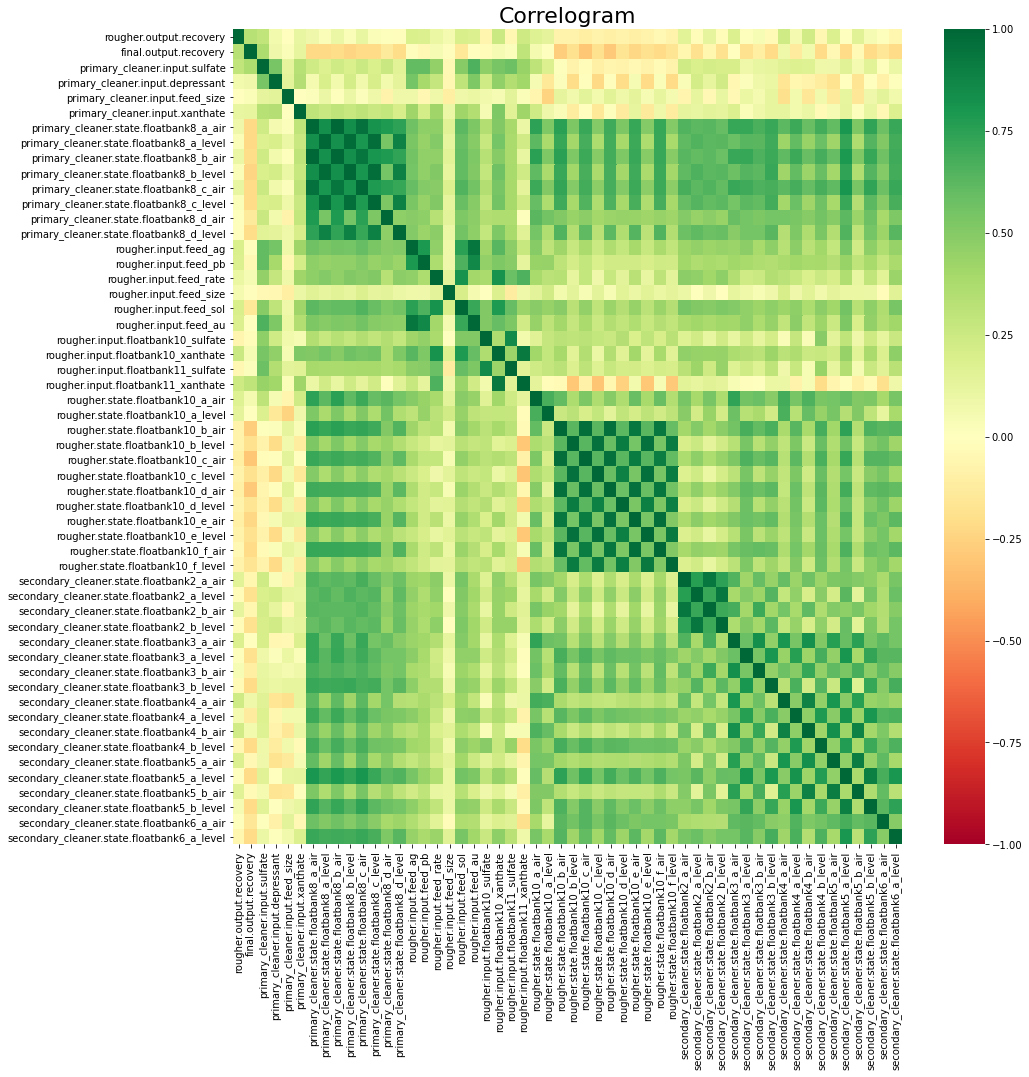

In [9]:
# Plot
plt.figure(figsize=(15,15))
sns.heatmap(df_train.corr(),
            cmap='RdYlGn',
            vmin=-1.0,
            vmax=1.0
           )

# Decorations
plt.title('Correlogram', fontsize=22)
plt.show()

Некоторые группы признаков сильно взаимосвязаны, и при необходимости от них можно будет избавиться.

В данных имеются пропуски. Можно удалить, а можно заполнить предыдущим значением

In [10]:
# print('До удаления пропусков:', df_train.shape)
# df_train = df_train.dropna()
# print('После удаления пропусков:', df_train.shape)

In [11]:
# заполняем пропуски предыдущими значениями
df_train = df_train.fillna(method='ffill')

Оценим распределения признаков

In [12]:
# для примера первые 5, но можно и все :)
for column in df_train.columns[:5]:
    fig = px.violin(df_train, x=column, box=True, orientation="h")
    fig.show()

# 2. Анализ данных

## 2.1. Концентрация металлов ( Au, Ag, Pb ) на различных этапах очистки

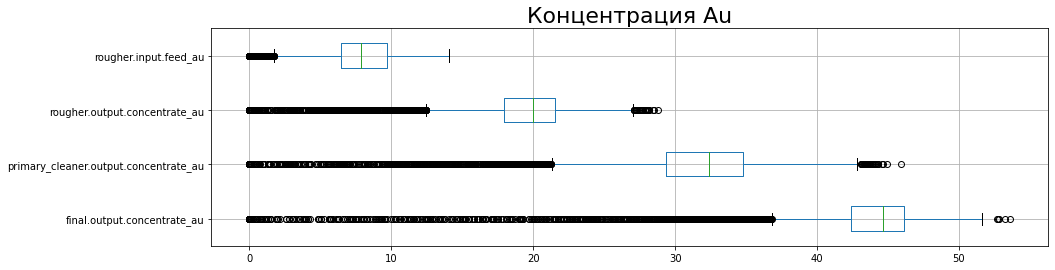

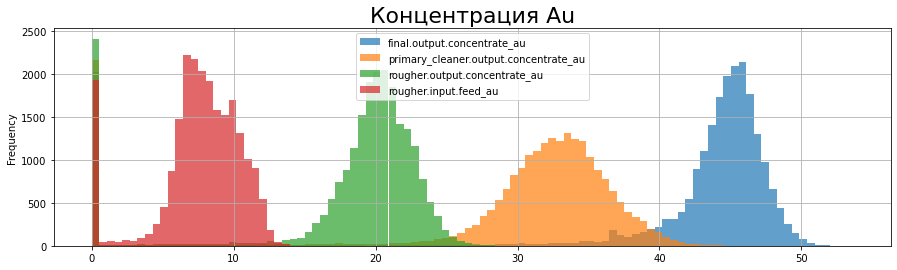

In [13]:
columns = [
    'final.output.concentrate_au',
    'primary_cleaner.output.concentrate_au',
    'rougher.output.concentrate_au',
    'rougher.input.feed_au',
]
df_full[columns].boxplot(figsize=(15,4),vert=False)
plt.title('Концентрация Au', fontsize=22)
plt.show()

df_full[columns].plot.hist(figsize=(15,4), bins=100, alpha=0.7, grid=True)
plt.title('Концентрация Au', fontsize=22)
plt.show()

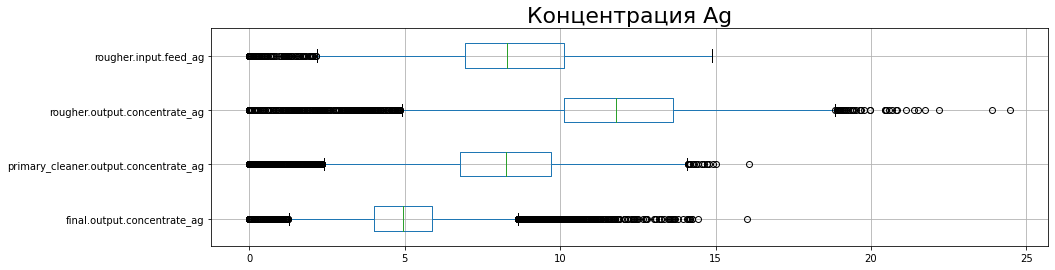

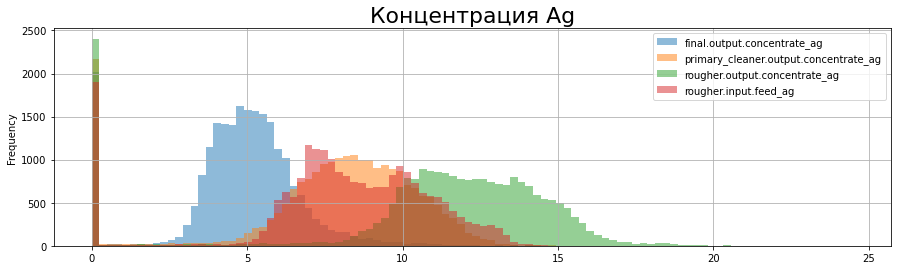

In [14]:
columns = [
    'final.output.concentrate_ag',
    'primary_cleaner.output.concentrate_ag',
    'rougher.output.concentrate_ag',
    'rougher.input.feed_ag',
]
df_full[columns].boxplot(figsize=(15,4),vert=False)

plt.title('Концентрация Ag', fontsize=22)
plt.show()


df_full[columns].plot.hist(figsize=(15,4), bins=100, alpha=0.5, grid=True)
plt.title('Концентрация Ag', fontsize=22)
plt.show()

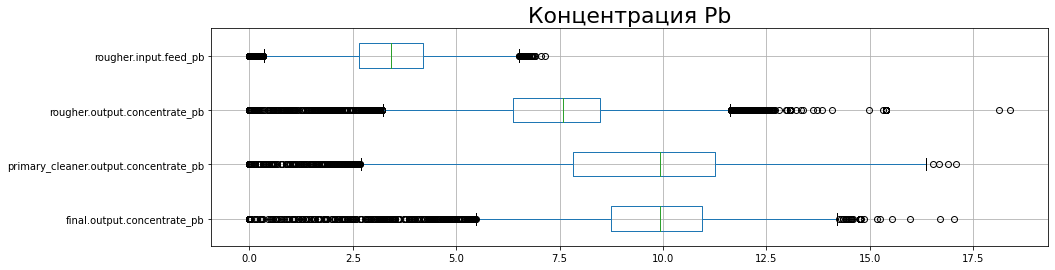

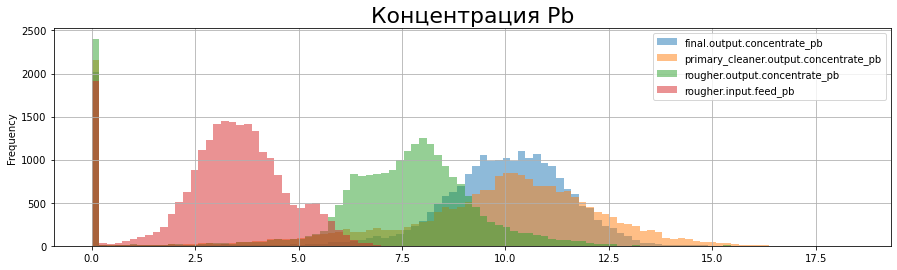

In [15]:
columns = [
    'final.output.concentrate_pb',
    'primary_cleaner.output.concentrate_pb',
    'rougher.output.concentrate_pb',
    'rougher.input.feed_pb',
]
df_full[columns].boxplot(figsize=(15,4),vert=False)
plt.title('Концентрация Pb', fontsize=22)
plt.show()

df_full[columns].plot.hist(figsize=(15,4), bins=100, alpha=0.5, grid=True)
plt.title('Концентрация Pb', fontsize=22)
plt.show()

Видно, что концентрация золота на каждом последующем этапе растет, что вполне логично. Т.к. цель компании - получение золота из сырья.

Остальные же химические элементы вторичны или вовсе не имеют значения.

## 2.2. Распределения размеров гранул сырья

In [16]:
columns = [
    'primary_cleaner.input.feed_size',
    'rougher.input.feed_size',
]

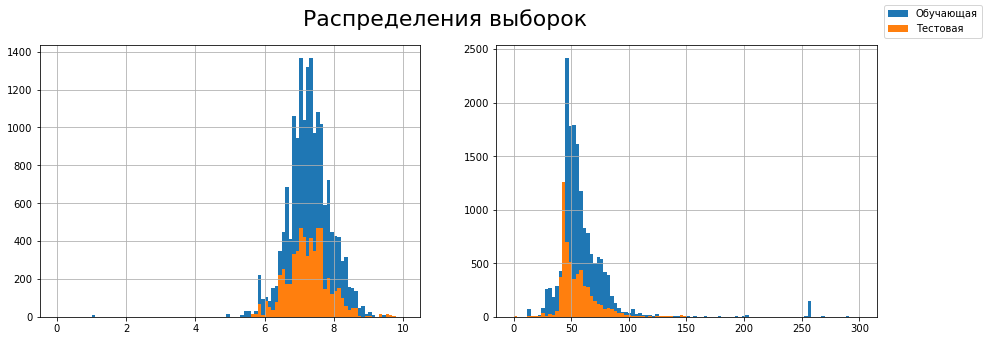

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

df_train[columns[0]].hist(bins=100, ax=ax[0], range=(0,10))
df_train[columns[1]].hist(bins=100, ax=ax[1], range=(0,300))

df_test[columns[0]].hist(bins=100, ax=ax[0], range=(0,10))
df_test[columns[1]].hist(bins=100, ax=ax[1], range=(0,300))

fig.suptitle('Распределения выборок', fontsize=22)
fig.legend(['Обучающая','Тестовая'])
plt.show()


In [18]:
df_train[columns].describe()

primary_cleaner.input.feed_size  rougher.input.feed_size
count                        16,860.00                16,860.00
mean                              7.30                    60.19
std                               0.62                    30.52
min                               1.08                     9.66
25%                               6.94                    47.55
50%                               7.29                    54.07
75%                               7.70                    65.40
max                              10.47                   484.97

In [19]:
df_test[columns].describe()

primary_cleaner.input.feed_size  rougher.input.feed_size
count                         5,856.00                 5,834.00
mean                              7.26                    55.94
std                               0.61                    22.72
min                               5.65                     0.05
25%                               6.89                    43.89
50%                               7.26                    50.00
75%                               7.65                    61.64
max                              15.50                   477.45

Визуально отличий не увидел, предположу, что существенных отклонений, способных повлиять на оценку модели, нет

## 2.3. Суммарная концентрация всех веществ на разных стадиях

In [20]:
print(*df_test.columns, sep='\n')

primary_cleaner.input.sulfate
primary_cleaner.input.depressant
primary_cleaner.input.feed_size
primary_cleaner.input.xanthate
primary_cleaner.state.floatbank8_a_air
primary_cleaner.state.floatbank8_a_level
primary_cleaner.state.floatbank8_b_air
primary_cleaner.state.floatbank8_b_level
primary_cleaner.state.floatbank8_c_air
primary_cleaner.state.floatbank8_c_level
primary_cleaner.state.floatbank8_d_air
primary_cleaner.state.floatbank8_d_level
rougher.input.feed_ag
rougher.input.feed_pb
rougher.input.feed_rate
rougher.input.feed_size
rougher.input.feed_sol
rougher.input.feed_au
rougher.input.floatbank10_sulfate
rougher.input.floatbank10_xanthate
rougher.input.floatbank11_sulfate
rougher.input.floatbank11_xanthate
rougher.state.floatbank10_a_air
rougher.state.floatbank10_a_level
rougher.state.floatbank10_b_air
rougher.state.floatbank10_b_level
rougher.state.floatbank10_c_air
rougher.state.floatbank10_c_level
rougher.state.floatbank10_d_air
rougher.state.floatbank10_d_level
rougher.state.f

Оценим по полному набору данных

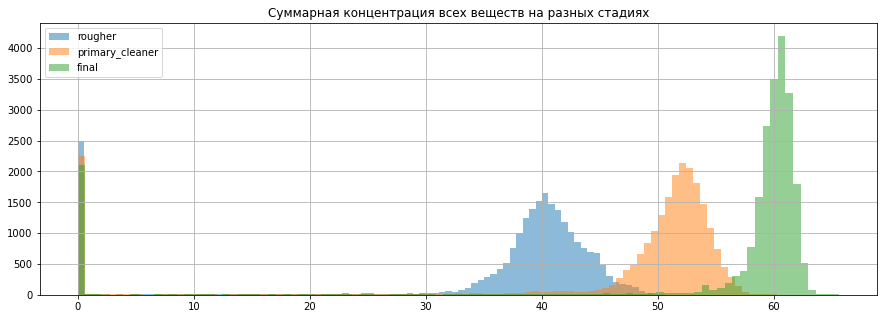

In [21]:
columns = [
    [
        'rougher.output.concentrate_ag',
        'rougher.output.concentrate_pb',
        'rougher.output.concentrate_au',
    ],
    [
        'primary_cleaner.output.concentrate_ag',
        'primary_cleaner.output.concentrate_pb',
        'primary_cleaner.output.concentrate_au',
    ],
    [
        'final.output.concentrate_ag',
        'final.output.concentrate_pb',
        'final.output.concentrate_au',
    ],
]
fig, ax = plt.subplots(figsize=(15,5))
for i in range(len(columns)):
    ax = df_full[columns[i]].agg("sum", axis="columns").hist(bins=100, alpha=0.5)
    
plt.legend(['rougher','primary_cleaner','final'])
plt.title('Суммарная концентрация всех веществ на разных стадиях')
plt.show()

Видим на гистограммах выбросы на значениях "0". Если бы эти признаки присутствовали в тестовом наборе данных, то однозначно необходимо было бы почистить. Но в `df_test` их нет, следовательно и в `df_train` таких признаков не будет.

Удаляю объекты ниже через индексы полного набора данных

In [22]:
for i in range(len(columns)):
    df_train = df_train.drop(df_train[df_full[columns[i]].agg("sum", axis="columns") < 10].index,
                             errors='ignore')


<ipython-input-22-4b7220705975>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-22-4b7220705975>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-22-4b7220705975>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



# 3. Модель

## 3.1. Функция для вычисления итоговой $sMAPE$
Метрика *sMAPE* вычисляется так:
$$
sMAPE = \frac1N \sum_{i=1}^N \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|)/2} \times 100\%
$$

Обозначения:
- $y_i$ - Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
- $\hat{y}_i$ - Значение предсказания для объекта с порядковым номером i , например, в тестовой выборке.
- $N$ - Количество объектов в выборке.
- $\sum_{i=1}^N$ - Суммирование по всем объектам выборки ( i меняется от 1 до N ).

Немного упростим, используя преймущества Pandas:

In [23]:
def smape(target, predict):
    predict = pd.Series(predict, index=target.index)
    res = (target-predict).abs()
    res /=(target.abs()+predict.abs())/2
    return res.mean()

def smape_final(target, predict):
    smape_rougher = smape(target.iloc[:,0], predict[:, 0])
    smape_final = smape(target.iloc[:,1], predict[:, 1])
    return smape_rougher*0.25 + smape_final*0.75

Сразу для GridSearchCV делаем счетчик, по которому будем подбирать параметры:

In [24]:
smape_score = make_scorer(smape_final, greater_is_better=False)

## 1.2. Обучение моделей

Разделяем данные

In [26]:
features_train = df_train.drop(columns=['rougher.output.recovery', 'final.output.recovery'])
target_train = df_train[['rougher.output.recovery', 'final.output.recovery']]

In [27]:
x_train, x_valid, y_train, y_valid = train_test_split(features_train, target_train, random_state=12345, test_size=0.25)

### LinearRegression

Оцениваем с кроссвалидацией значения sMAPE (отрицательные значения нужно брать по модулю)

In [28]:
model = LinearRegression()
cross_validate(model, x_train, y_train, cv=5, scoring=smape_score)['test_score']

array([-0.07783647, -0.08034677, -0.07744559, -0.07634722, -0.07821617])

Обучаем на `train` и проверяем на `valid`

In [29]:
model.fit(x_train, y_train)

predict = model.predict(x_valid)

print('sMAPE =', smape_final(y_valid, predict))

sMAPE = 0.07700642309339367


### RandomForestRegressor

Теперь посмотрим, как работает случайный лес

In [30]:
# Количество деревьев
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 10)]
# Максимальное количество уровней в дереве
max_depth = [int(x) for x in np.linspace(25, 40, num = 5)]
max_depth.append(None)

grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

Ячейку ниже закомментировал, т.к. долго считает

In [31]:
# %%time
# model = RandomForestRegressor(max_features='sqrt')
# # Случайный поиск параметров
# search_hyp_par = GridSearchCV(
#     estimator = model,
#     param_grid = grid,
#     cv = 3,
#     verbose=3,
# #     random_state=12345,
#     scoring=smape_score
# )

# search_hyp_par.fit(x_train, y_train)
# search_hyp_par.best_params_

Можно заметить, что итоговый `score` с учетом кроссвалидации расположен в районе 0.053, практически независимо от гиперпараметров.

Обучим модель случайного леса и посмотрим значение sMAPE

In [32]:
%%time
model = RandomForestRegressor(
    n_estimators = 150,
    max_features = 'sqrt',
    max_depth = 25
)
model.fit(x_train, y_train)
predict = model.predict(x_valid)
print('sMAPE =', smape_final(y_valid, predict))

sMAPE = 0.0536883771348708
Wall time: 13.1 s


sMAPE почти на 2.5% лучше, проверим модель на адекватность:

In [33]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(x_train, y_train)
predict = dummy_regr.predict(x_valid)
print('median\tsMAPE =', smape_final(y_valid, predict))

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(x_train, y_train)
predict = dummy_regr.predict(x_valid)
print('mean\tsMAPE =', smape_final(y_valid, predict))

median	sMAPE = 0.09672264569741892
mean	sMAPE = 0.09774375242550193


Очевидно, случайный лес дает лучшие показатели. Обучаем на полном наборе данных `df_train` и проверяем на `df_test`

In [34]:
model = RandomForestRegressor(
    n_estimators = 150,
    max_features = 'sqrt',
    max_depth = 25
)
model.fit(features_train, target_train)
# оставим только неообходимые признаки и удалим некорректные данные
features_test = df_test.dropna()
target_test = df_full.loc[features_test.index][['rougher.output.recovery', 'final.output.recovery']]

predict = model.predict(features_test)

print('sMAPE =', smape_final(target_test, predict))

sMAPE = 0.09700206728999831


Интересный результат, проверим линейную регрессию и константную модель:

In [35]:
model = LinearRegression()
model.fit(features_train, target_train)

predict = model.predict(features_test)

print('sMAPE =', smape_final(target_test, predict))

sMAPE = 0.09215760054341823


In [36]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(features_train, target_train)

predict = dummy_regr.predict(features_test)

print('median\tsMAPE =', smape_final(target_test, predict))

median	sMAPE = 0.09453123241666662


In [37]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)

predict = dummy_regr.predict(features_test)

print('mean\tsMAPE =', smape_final(target_test, predict))

mean	sMAPE = 0.0994937948050281


## 1.3. Итоговый sMape

Лучший показатель для линейной регрессии.

Итоговая метрика складывается из двух величин:

$$
sMAPE = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)
$$

In [41]:
model = LinearRegression()
model.fit(features_train, target_train)

predict = model.predict(features_test)

print('Итоговое sMAPE =', smape_final(target_test, predict))

Итоговое sMAPE = 0.09215760054341823
